# Vague d'impulsion

In [1]:
from pathlib import Path
from yaml import dump
from config import config
from insert_dam import insert_dam
from makeqinit_matplotlib import make_qinit
from make_tools import make_new, make_output, make_data
from energy import compute_energies_masses, plot as plot_energy_mass

import topo_utils

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LightSource

from clawpack.geoclaw import fgout_tools
from clawpack.geoclaw import fgmax_tools
from clawpack.geoclaw import topotools

In [ ]:
print("config:")
for k, v in config.items():
    print(f"\t{k}: {v}")

# Modify the parameters as you wish
config["any_param"] = ...

# Update it if needed for later
if False:
    with open("config.yaml", "w") as stream:
        dump(config, stream)

AVAC_outdir: /media/giboul/Data/Trift/AVAC/_output11
base_bathymetry: ../avac_trift/topo.asc
bathymetry: topo_trift.asc
topo_type: 3
output_format: binary64
t0: 0.0
qinit: ['qinit.xyz']
world_png: topo.png
flood_dilation: 20
flood_seed: ['nan', 'nan']
nout: 100
mode: src
fgout_fgno: 2
fgmax_fgno: 0
min_alt_avac: 1776
lake_alt: 1767
bc_size: 100
cell_size: 3
amr_ratios: {'x': [2, 4, 8], 'y': [2, 4, 8], 't': [2, 4, 8]}
max_refinement: 4
dry_tolerance: 1e-3
verbosity: 0
duration: 80
dams: dam_trift.shp
dam_alts: 1771.2
lower: [2669815, 1170245]
upper: [2670935, 1172105]


## Loading DEM

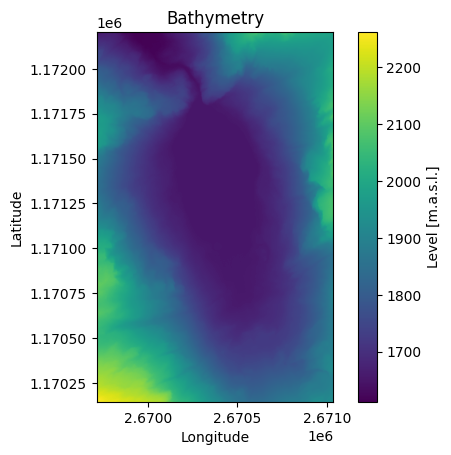

In [3]:
bbox = config["lower"]+config["upper"]
dem_margin = 100  # m
bbox[0] -= dem_margin
bbox[1] -= dem_margin
bbox[2] += dem_margin
bbox[3] += dem_margin
w, s, e, n = bbox
extent = w, e, s, n
x, y, Z = topo_utils.read_raster(config["base_bathymetry"],
                                 bbox,
                                 config["cell_size"])

plt.title("Bathymetry")
plt.imshow(Z, extent=extent)
plt.colorbar(label="Level [m.a.s.l.]")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Hillshade

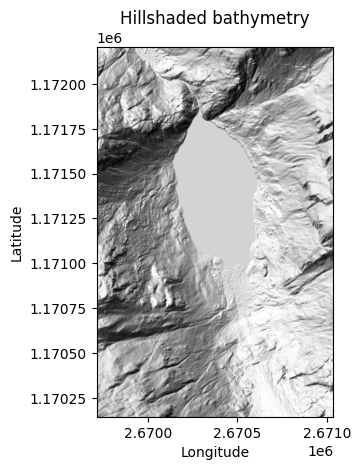

In [4]:
plt.title("Hillshaded bathymetry")
ls = LightSource(azdeg=315, altdeg=45)
plt.imshow(ls.hillshade(Z), cmap="gray", extent=extent)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

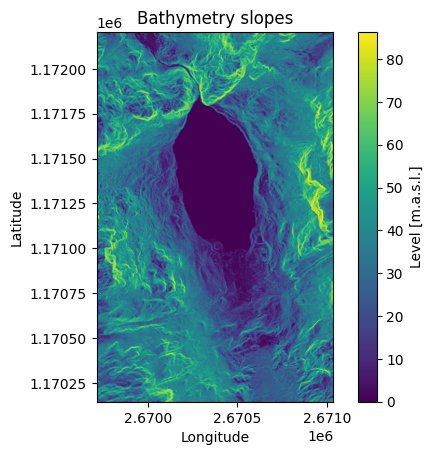

In [5]:
plt.title("Bathymetry slopes")
slope = np.sqrt(np.square(np.gradient(Z, config["cell_size"])).sum(axis=0))
slope = np.rad2deg(np.arctan(slope))
plt.imshow(slope, extent=extent)
plt.colorbar(label="Level [m.a.s.l.]")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## AVAC

Reading fgout grid info from 
    /media/giboul/Data/Trift/AVAC/_output11/fgout_grids.data
Reading input for fgno=2, point_style = 2 
Found fgout grid q_out_vars =  [1, 2, 3, 4]
Using this mapping to fgout variable names: 
      qmap =  {'h': 1, 'hu': 2, 'hv': 3, 'eta': 4, 'B': 5}
    Reading  Frame 1 at t = 0  from outdir = /media/giboul/Data/Trift/AVAC/_output11
    Reading  Frame 90 at t = 90  from outdir = /media/giboul/Data/Trift/AVAC/_output11


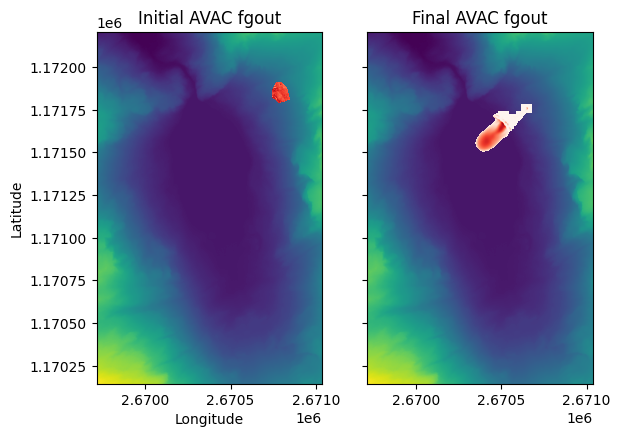

In [6]:
avac_fgout = fgout_tools.FGoutGrid(config["fgout_fgno"], config["AVAC_outdir"])
avac_fgout.read_fgout_grids_data()

avac_hinit = avac_fgout.read_frame(1).h
avac_hfinal = avac_fgout.read_frame(avac_fgout.nout).h

avac_hinit = np.where(avac_hinit>0, avac_hinit, np.nan)
avac_hfinal = np.where(avac_hfinal>0, avac_hfinal, np.nan)

fig, axes = plt.subplots(ncols=2, sharex="all", sharey="all")
for ax in axes:
    ax.imshow(Z, extent=extent)

avac_fgout.extent = avac_fgout.x1, avac_fgout.x2, avac_fgout.y1, avac_fgout.y2
axes[1].imshow(avac_hfinal.T, extent=avac_fgout.extent, origin="lower", cmap="Reds")
axes[0].imshow(avac_hinit.T, extent=avac_fgout.extent, origin="lower", cmap="Reds")

axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

axes[0].set_title("Initial AVAC fgout")
axes[1].set_title("Final AVAC fgout")

for ax in axes:
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
plt.show()

## Insert dam

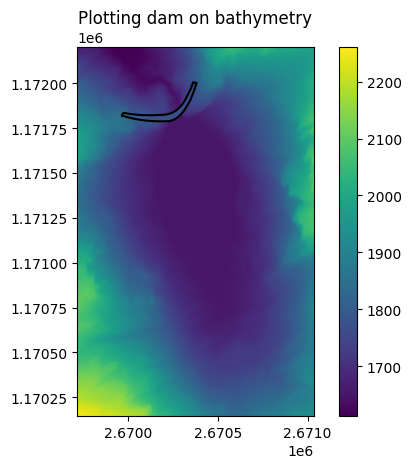

In [7]:
dams = topo_utils.read_poly(config["dams"])
Z, bboxes = insert_dam(dams, config["dam_alts"], x, y, Z)
for i, bbox in enumerate(bboxes):
    np.savetxt(f"dam{i}.bbox", bbox)

plt.title("Plotting dam on bathymetry")
plt.imshow(Z, extent=extent)
plt.plot(*dams[0].T, c="k")
plt.colorbar()
plt.show()

## Initial solution (lake) and initially fine regions

In [8]:
flood_seed = 2.67e6 + 400, 1.1712e6
x0, y0, eta0, qinit_bbox = make_qinit(x, y, Z,
                                  config["lake_alt"],
                                  flood_seed=flood_seed,
                                  dilation_radius=config["flood_dilation"])
np.savetxt("qinit.bbox", qinit_bbox)

Filling lake


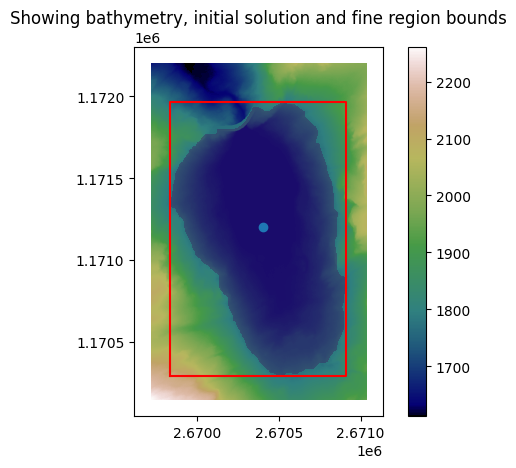

In [9]:
regions = [np.loadtxt(region_file) for region_file in Path().glob("qinit*.bbox")]
# regions = [np.loadtxt(path) for path in Path().glob("dam*.bbox")]

plt.title("Showing bathymetry, initial solution and fine region bounds")
extent0 = x0.min(), x0.max(), y0.min(), y0.max()
plt.imshow(Z, extent=extent, cmap="gist_earth")
plt.colorbar()
plt.imshow(np.where(eta0>Z.min(), eta0, np.nan), extent=extent0, alpha=0.3)
plt.scatter(*flood_seed)

for region in regions:
    w, e, s, n = region
    plt.plot([w, e, e, w, w], [s, s, n, n, s], c="r")
plt.xlim(np.array([-100, 100])+plt.xlim())
plt.ylim(np.array([-100, 100])+plt.ylim())
plt.show()

## Exporting the DEMs for geoclaw

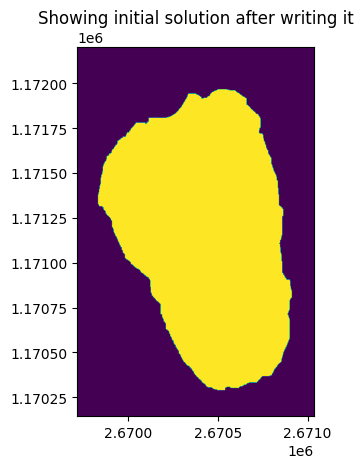

In [10]:
topo = topotools.Topography()
topo.x = x0
topo.y = y0[::-1]
topo.Z = eta0[::-1, :]
topo.write(config["qinit"][0], topo_type=1)  # There can be multiple qinit files

topo = topotools.Topography(config["qinit"][0])

plt.title("Showing initial solution after writing it")
plt.imshow(topo.Z, extent=(topo.x.min(), topo.x.max(), topo.y.min(), topo.y.max()), origin="lower")
plt.show()

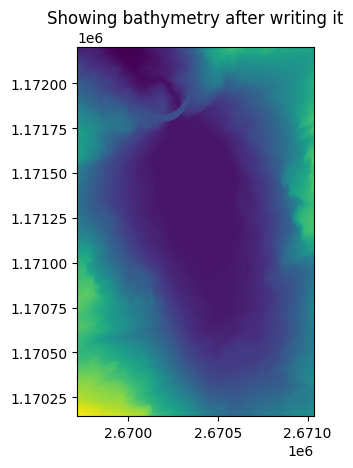

In [11]:
topo = topotools.Topography()
topo.x = x
topo.y = y[::-1]  # TODO
topo.Z = Z[::-1, :]
topo.write(config["bathymetry"], topo_type=config["topo_type"])

topo = topotools.Topography(config["bathymetry"])
plt.title("Showing bathymetry after writing it")
plt.imshow(topo.Z, extent=(topo.x.min(), topo.x.max(), topo.y.min(), topo.y.max()), origin="lower")
plt.show()

## Make executable, data & output

In [12]:
if not Path("xgeoclaw").is_file():
    exit_code = make_new()
    assert exit_code == 1, "Compilation failed! See logs above."

In [13]:
exit_code = make_data(AVAC_outdir=config["AVAC_outdir"], outdir="_output")

Makefile:71: warning: overriding recipe for target 'all'
/home/giboul/.venvs/claw/src/clawpack/clawutil/src/Makefile.common:323: warning: ignoring old recipe for target 'all'
Makefile:78: warning: overriding recipe for target 'data'
/home/giboul/.venvs/claw/src/clawpack/clawutil/src/Makefile.common:230: warning: ignoring old recipe for target 'data'


rm -f .data
python setrun.py         geoclaw                   
Reading fgout grid info from 
    /media/giboul/Data/Trift/AVAC/_output11/fgout_grids.data
Reading input for fgno=1, point_style = 2 
Found fgout grid q_out_vars =  [1, 2, 3, 4]
Using this mapping to fgout variable names: 
      qmap =  {'h': 1, 'hu': 2, 'hv': 3, 'eta': 4, 'B': 5}
Coarsest cells size : 224.00, 206.67
Finest cells size : 3.50, 3.23

---------------------------------------------- 
fgout grid 1 has point_style = 2
   specifying fgout grid with shape 1120 by 1860, with  2083200 points
   lower left  = (2669815.0000000000,1170245.0000000000)
   upper right = (2670935.0000000000,1172105.0000000000)
   dx = 1.0000000000e+00,  dy = 1.0000000000e+00

---------------------------------------------- 
fgmax grid 1 has point_style = 2
   specifying fixed grid with shape 1121 by 1861, with  2086181 points
   lower left  = (2669815.0000000000,1170245.0000000000)
   upper right = (2670935.0000000000,1172105.0000000000)
   

In [14]:
exit_code = make_output(OUTDIR="_output")

Makefile:71: warning: overriding recipe for target 'all'
/home/giboul/.venvs/claw/src/clawpack/clawutil/src/Makefile.common:323: warning: ignoring old recipe for target 'all'
Makefile:78: warning: overriding recipe for target 'data'
/home/giboul/.venvs/claw/src/clawpack/clawutil/src/Makefile.common:230: warning: ignoring old recipe for target 'data'


rm -f .output
python /home/giboul/.venvs/claw/src/clawpack/clawutil/src/python/clawutil/runclaw.py xgeoclaw                  _output \
True None . False False None 
==> runclaw: Will take data from  /home/giboul/Desktop/TriftGeoClaw
==> runclaw: Will write output to  /home/giboul/Desktop/TriftGeoClaw/_output
==> runclaw: Removing all old fort/gauge files in  /home/giboul/Desktop/TriftGeoClaw/_output

==> Running with command:
    /home/giboul/Desktop/TriftGeoClaw/xgeoclaw
Reading data file: claw.data
         first 5 lines are comments and will be skipped
Reading data file: amr.data
         first 5 lines are comments and will be skipped
  
 Running amrclaw ...  
  
Reading data file: setprob.data
         first 5 lines are comments and will be skipped
Reading data file: /media/giboul/Data/Trift/AVAC/_output11/fgout_grids.data
         first 5 lines are comments and will be skipped
 +++ q_out_vars: T T T T F F
 +++ nqout =            4
 +++ q_out_vars: T T T T F F
 +++ nqout =         

Traceback (most recent call last):
  File "/home/giboul/.venvs/claw/src/clawpack/clawutil/src/python/clawutil/runclaw.py", line 341, in <module>
    runclaw(*args)
  File "/home/giboul/.venvs/claw/src/clawpack/clawutil/src/python/clawutil/runclaw.py", line 242, in runclaw
    proc = subprocess.check_call(cmd_split,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/subprocess.py", line 408, in check_call
    retcode = call(*popenargs, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/subprocess.py", line 391, in call
    return p.wait(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/subprocess.py", line 1264, in wait
    return self._wait(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/subprocess.py", line 2053, in _wait
    (pid, sts) = self._try_wait(0)
                 ^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/subprocess.py", line 2011, in _try_wait
    (pid, sts)

KeyboardInterrupt: 

## Results (fgmax): maximum values

In [ ]:
fg = fgmax_tools.FGmaxGrid()
fg.outdir = "_output"
fg.read_fgmax_grids_data(1, Path("_output") / "fgmax_grids.data")
fg.read_output()
fg.extent = fg.x1, fg.x2, fg.y1, fg.y2

Reading input for fgno=1, point_style = 2 
Reading _output/fgmax0001.txt ...


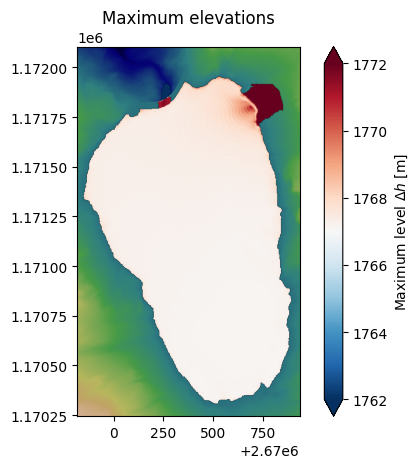

In [ ]:
amplitude = 5
plt.title("Maximum elevations")
plt.imshow(Z, extent=extent, cmap="gist_earth")
plt.imshow(np.where(fg.h>0, fg.B+fg.h, np.nan).T, extent=fg.extent, origin="lower", cmap="RdBu_r", vmin=config["lake_alt"]-amplitude, vmax=config["lake_alt"]+amplitude)
plt.colorbar(label=r"Maximum level $\Delta h$ [m]", extend="both")
plt.show()

## Results (fgout)

### Initial frame

Reading fgout grid info from 
    _output/fgout_grids.data
Reading input for fgno=1, point_style = 2 
Found fgout grid q_out_vars =  [1, 2, 3, 4]
Using this mapping to fgout variable names: 
      qmap =  {'h': 1, 'hu': 2, 'hv': 3, 'eta': 4, 'B': 5}
    Reading  Frame 1 at t = 0  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output


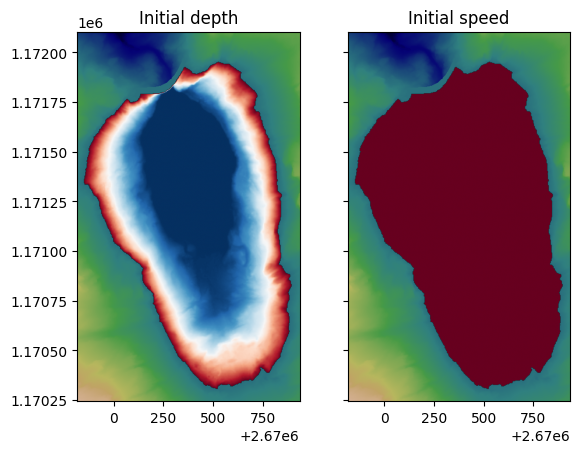

In [ ]:
fgout = fgout_tools.FGoutGrid(1, "_output")
fgout.read_fgout_grids_data()
fgout.extent = fgout.x1, fgout.x2, fgout.y1, fgout.y2

frame_init = fgout.read_frame(1)
frame_init.V = np.sqrt((frame_init.hu/(1e-10+frame_init.h))**2 + (frame_init.hv/(1e-10+frame_init.h))**2)

fig, axes = plt.subplots(ncols=2, sharex="row", sharey="row")
for ax in axes:
    ax.imshow(Z, extent=extent, cmap="gist_earth")
axes[0].imshow(np.where(frame_init.h.T>0, frame_init.h.T, np.nan), extent=fgout.extent, origin="lower", cmap="RdBu")
axes[1].imshow(np.where(frame_init.h.T>0, frame_init.V.T, np.nan), extent=fgout.extent, origin="lower", cmap="RdBu")
axes[0].set_title("Initial depth")
axes[1].set_title("Initial speed")
plt.show()

## Finding maximums (over fgout)

In [ ]:
q_max = np.zeros_like(frame_init.q)
for i in range(1, fgout.nout):
    q_max = np.maximum(q_max, fgout.read_frame(i).q)

hmax = q_max[0]
vmax = np.sqrt((q_max[1]/(1e-10+q_max[0]))**2 + (q_max[2]/(1e-10+q_max[0]))**2)

    Reading  Frame 2 at t = 0.808081  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 3 at t = 1.61616  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 4 at t = 2.42424  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 5 at t = 3.23232  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 6 at t = 4.0404  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 7 at t = 4.84848  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 8 at t = 5.65657  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 9 at t = 6.46465  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 10 at t = 7.27273  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 11 at t = 8.08081  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 12 at t = 8.88889  from outdir = /home/giboul/Des

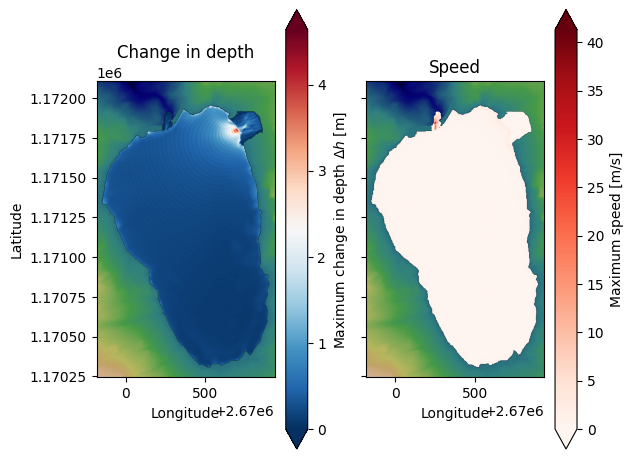

In [ ]:
fig, (axh, axv) = plt.subplots(ncols=2, sharex="all", sharey="all", layout="tight")

for ax in (axh, axv):
    ax.imshow(Z, extent=extent, cmap="gist_earth")
axv.set_xlabel("Longitude")
axh.set_xlabel("Longitude")
axh.set_ylabel("Latitude")

axh.set_title("Change in depth")
axv.set_title("Speed")

imh = axh.imshow(np.where(hmax>0, hmax-frame_init.h, np.nan).T, extent=fgout.extent, origin="lower", cmap="RdBu_r")
fig.colorbar(imh, ax=axh, location="right", label=r"Maximum change in depth $\Delta h$ [m]", extend="both")

imv = axv.imshow(np.where(hmax>0, vmax, np.nan).T, extent=fgout.extent, origin="lower", cmap="Reds")
fig.colorbar(imv, ax=axv, location="right", label="Maximum speed [m/s]", extend="both")
plt.show()

## Energy diagram

In [ ]:
data = compute_energies_masses("_output", avac_fgout_fgno=config["fgout_fgno"])
(t_AVAC, E_AVAC, M_AVAC), (t, E_avalanche, M_avalanche), (t_lake, E_lacke, M_lake) = data

Reading fgout grid info from 
    _output/fgout_grids.data
Reading input for fgno=1, point_style = 2 
Found fgout grid q_out_vars =  [1, 2, 3, 4]
Using this mapping to fgout variable names: 
      qmap =  {'h': 1, 'hu': 2, 'hv': 3, 'eta': 4, 'B': 5}
Reading fgout grid info from 
    /home/giboul/Desktop/TriftGeoClaw/../avac_trift/_output/fgout_grids.data
Reading input for fgno=2, point_style = 2 
Found fgout grid q_out_vars =  [1, 2, 3, 4]
Using this mapping to fgout variable names: 
      qmap =  {'h': 1, 'hu': 2, 'hv': 3, 'eta': 4, 'B': 5}
    Reading  Frame 1 at t = 0  from outdir = /home/giboul/Desktop/avac_trift/_output
    Reading  Frame 2 at t = 1.01124  from outdir = /home/giboul/Desktop/avac_trift/_output
    Reading  Frame 3 at t = 2.02247  from outdir = /home/giboul/Desktop/avac_trift/_output
    Reading  Frame 4 at t = 3.03371  from outdir = /home/giboul/Desktop/avac_trift/_output
    Reading  Frame 5 at t = 4.04494  from outdir = /home/giboul/Desktop/avac_trift/_output
   

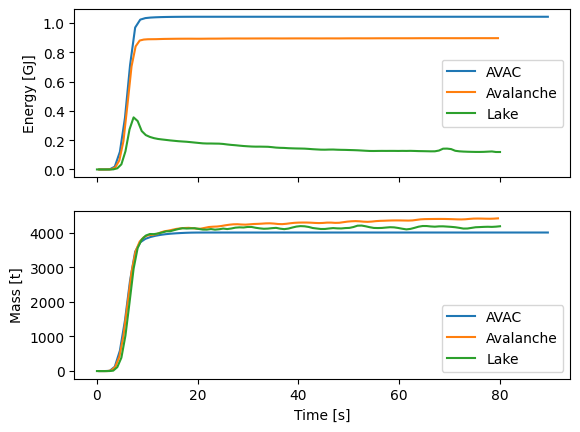

In [ ]:
plot_energy_mass(t_AVAC, E_AVAC, M_AVAC, t, E_avalanche, M_avalanche, t_lake, E_lacke, M_lake)
plt.show()